In [8]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, '..')
from lib import models, graph, coarsening, utils

import tensorflow as tf
import numpy as np
import time

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import argparse
import os

# Define the argument parser
parser = argparse.ArgumentParser()

# Graphs.
parser.add_argument('--number_edges', type=int, default=16, help='Graph: minimum number of edges per vertex.')
parser.add_argument('--metric', type=str, default='cosine', help='Graph: similarity measure (between features).')
# TODO: change cgcnn for combinatorial Laplacians.
parser.add_argument('--normalized_laplacian', type=bool, default=True, help='Graph Laplacian: normalized.')
parser.add_argument('--coarsening_levels', type=int, default=0, help='Number of coarsened graphs.')

parser.add_argument('--dir_data', type=str, default=os.path.join('data', 'mnist'), help='Directory to store data.')
parser.add_argument('--val_size', type=int, default=400, help='Size of the validation set.')

# Parse the arguments
FLAGS, unparsed = parser.parse_known_args()

# You can now access the arguments as FLAGS.number_edges, FLAGS.metric, etc.
print(f'number_edges: {FLAGS.number_edges}')
print(f'metric: {FLAGS.metric}')
print(f'normalized_laplacian: {FLAGS.normalized_laplacian}')
print(f'coarsening_levels: {FLAGS.coarsening_levels}')
print(f'dir_data: {FLAGS.dir_data}')
print(f'val_size: {FLAGS.val_size}')


number_edges: 16
metric: cosine
normalized_laplacian: True
coarsening_levels: 0
dir_data: data/mnist
val_size: 400


# Feature graph

In [6]:
import tensorflow_datasets

mnist = tensorflow_datasets.load('mnist')


2024-08-29 21:46:35.490927: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-29 21:46:35.491170: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-29 21:46:35.529116: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [8]:
import tensorflow as tf
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 3s 0us/step


In [9]:
train_data = mnist.train_images.astype(np.float32)


AttributeError: 'dict' object has no attribute 'train_images'

6848 > 6272 edges
Layer 0: M_0 = |V| = 784 nodes (0 added),|E| = 6848 edges
Execution time: 0.09s


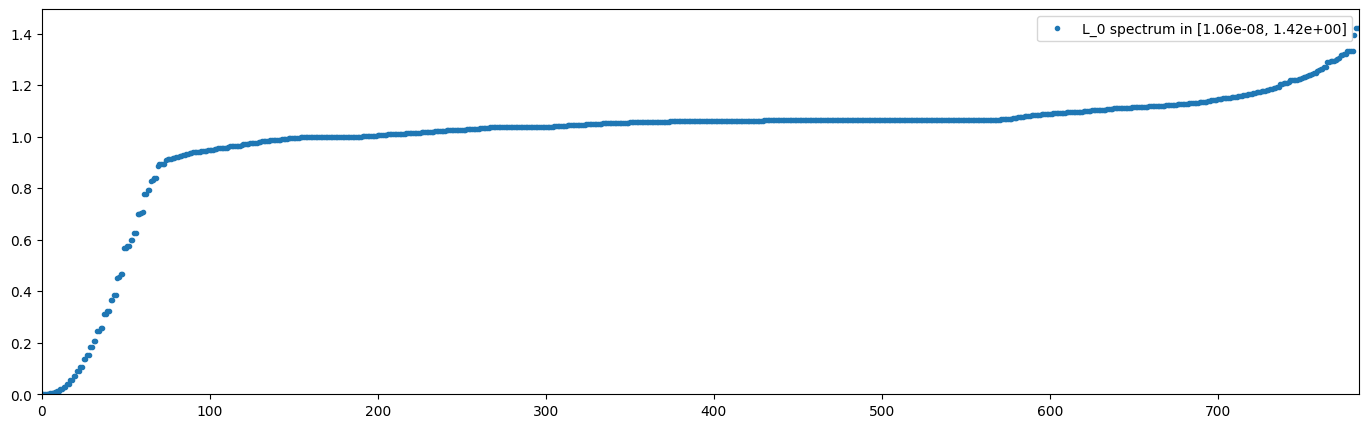

In [10]:
def grid_graph(m, corners=False):
    z = graph.grid(m)
    dist, idx = graph.distance_sklearn_metrics(z, k=FLAGS.number_edges, metric=FLAGS.metric)
    A = graph.adjacency(dist, idx)

    # Connections are only vertical or horizontal on the grid.
    # Corner vertices are connected to 2 neightbors only.
    if corners:
        import scipy.sparse
        A = A.toarray()
        A[A < A.max()/1.5] = 0
        A = scipy.sparse.csr_matrix(A)
        print('{} edges'.format(A.nnz))

    print("{} > {} edges".format(A.nnz//2, FLAGS.number_edges*m**2//2))
    return A

t_start = time.process_time()
A = grid_graph(28, corners=False)
A = graph.replace_random_edges(A, 0)
graphs, perm = coarsening.coarsen(A, levels=FLAGS.coarsening_levels, self_connections=False)
L = [graph.laplacian(A, normalized=True) for A in graphs]
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
graph.plot_spectrum(L)
del A

In [30]:
# Chargement des jeux de données MNIST
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
val_images, val_labels = test_images[:5000], test_labels[:5000]
test_images, test_labels = test_images[5000:], test_labels[5000:]

# Prétraitement des données (conversion en float32 et normalisation)
train_data = train_images.astype(np.float32) 
val_data = val_images.astype(np.float32) 
test_data = test_images.astype(np.float32)

In [7]:
import tensorflow as tf
import numpy as np
import time

# Chargement des jeux de données MNIST
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
val_images, val_labels = test_images[:5000], test_labels[:5000]
test_images, test_labels = test_images[5000:], test_labels[5000:]

# Prétraitement des données (conversion en float32 et normalisation)
train_data = train_images.astype(np.float32)
val_data = val_images.astype(np.float32) 
test_data = test_images.astype(np.float32) 
# Aplatir les images de [28, 28] à [784]
train_data = train_data.reshape(-1, 28 * 28)
val_data = val_data.reshape(-1, 28 * 28)
test_data = test_data.reshape(-1, 28 * 28)

# Récupération des labels (les labels sont déjà dans le bon format)
train_labels = train_labels
val_labels = val_labels
test_labels = test_labels

# Supposons que `perm` est une permutation définie auparavant
perm = np.random.permutation(train_data.shape[1])

def perm_data(data, perm):
    # Cette fonction doit être définie dans le module `coarsening`
    # Par exemple, si elle réorganise les pixels de chaque image
    return data[:, perm]

# Début du chronométrage de l'exécution
t_start = time.process_time()

# Permutation des données
train_data = coarsening.perm_data(train_data, perm)
val_data = coarsening.perm_data(val_data, perm)
test_data = coarsening.perm_data(test_data, perm)

# Affichage du temps d'exécution
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))

# Suppression de la variable `perm`
del perm


Execution time: 0.71s


6848 > 6272 edges
Layer 0: M_0 = |V| = 784 nodes (0 added),|E| = 6848 edges
Execution time: 0.11s


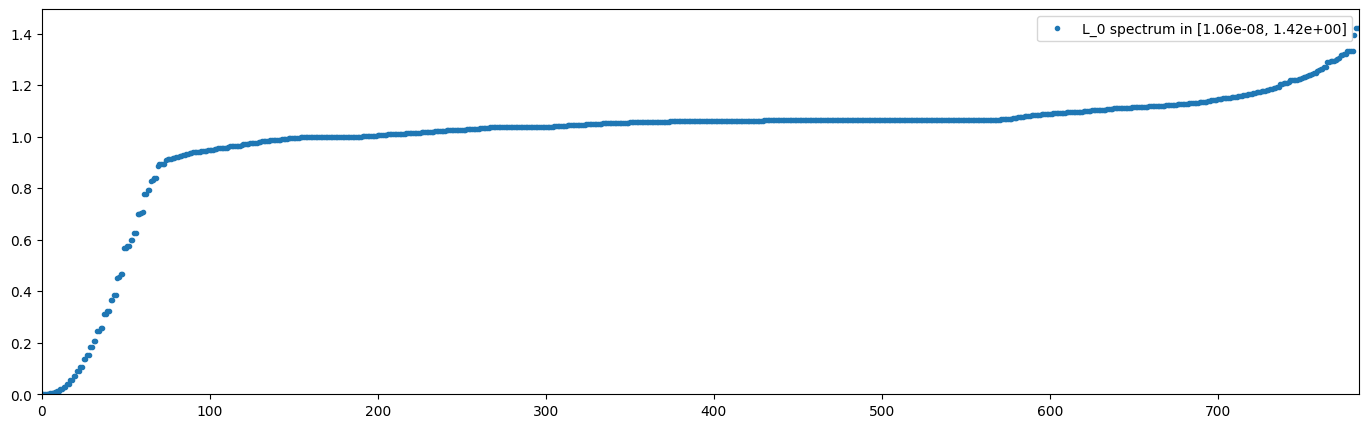

In [3]:
def grid_graph(m, corners=False):
    z = graph.grid(m)
    dist, idx = graph.distance_sklearn_metrics(z, k=FLAGS.number_edges, metric=FLAGS.metric)
    A = graph.adjacency(dist, idx)

    # Connections are only vertical or horizontal on the grid.
    # Corner vertices are connected to 2 neightbors only.
    if corners:
        import scipy.sparse
        A = A.toarray()
        A[A < A.max()/1.5] = 0
        A = scipy.sparse.csr_matrix(A)
        print('{} edges'.format(A.nnz))

    print("{} > {} edges".format(A.nnz//2, FLAGS.number_edges*m**2//2))
    return A

t_start = time.process_time()
A = grid_graph(28, corners=False)
A = graph.replace_random_edges(A, 0)
graphs, perm = coarsening.coarsen(A, levels=FLAGS.coarsening_levels, self_connections=False)
L = [graph.laplacian(A, normalized=True) for A in graphs]
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
graph.plot_spectrum(L)
del A

# Data

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds

(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

2024-08-29 10:16:41.130976: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-29 10:16:41.131472: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-29 10:16:42.262303: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [24]:

import tensorflow as tf
import tensorflow_datasets as tfds

(train_data, test_data), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

# Convert datasets to numpy arrays
train_data = np.array([image.numpy() for image, _ in train_data]).astype(np.float32)
train_labels = np.array([label.numpy() for _, label in train_data])
test_data = np.array([image.numpy() for image, _ in test_data]).astype(np.float32)
test_labels = np.array([label.numpy() for _, label in test_data])

# Split validation data from training data
val_data = train_data[:FLAGS.val_size]
val_labels = train_labels[:FLAGS.val_size]
train_data = train_data[FLAGS.val_size:]
train_labels = train_labels[FLAGS.val_size:]

# Assuming coarsening is a module you have defined elsewhere
import coarsening

t_start = time.process_time()
train_data = coarsening.perm_data(train_data, perm)
val_data = coarsening.perm_data(val_data, perm)
test_data = coarsening.perm_data(test_data, perm)
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
del perm

/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


RuntimeError: `tf.data.Dataset` only supports Python-style iteration in eager mode or within tf.function.

In [25]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np  # Added numpy import
import time  # Added time import

# Load the MNIST dataset
(train_data, test_data), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

# Convert datasets to numpy arrays
train_images = np.array([image.numpy() for image, _ in train_data]).astype(np.float32)
train_labels = np.array([label.numpy() for _, label in train_data])
test_images = np.array([image.numpy() for image, _ in test_data]).astype(np.float32)
test_labels = np.array([label.numpy() for _, label in test_data])

# Assuming FLAGS.val_size is defined elsewhere
# Split validation data from training data
val_images = train_images[:FLAGS.val_size]
val_labels = train_labels[:FLAGS.val_size]
train_images = train_images[FLAGS.val_size:]
train_labels = train_labels[FLAGS.val_size:]



# Assuming perm is defined elsewhere
t_start = time.process_time()
train_images = coarsening.perm_data(train_images, perm)
val_images = coarsening.perm_data(val_images, perm)
test_images = coarsening.perm_data(test_images, perm)
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
del perm  # This assumes perm is no longer needed


RuntimeError: `tf.data.Dataset` only supports Python-style iteration in eager mode or within tf.function.

In [4]:
import tensorflow_datasets as tfds
import numpy as np
import tensorflow as tf

# Load MNIST dataset
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

# Function to convert tf.data.Dataset to numpy arrays
def dataset_to_numpy(dataset):
    images = []
    labels = []
    for image, label in tfds.as_numpy(dataset):
        images.append(image)
        labels.append(label)
    return np.array(images).astype(np.float32), np.array(labels)

# Convert datasets to numpy arrays
train_images, train_labels = dataset_to_numpy(ds_train)
test_images, test_labels = dataset_to_numpy(ds_test)

# Configuration dictionary
common = {
    'dir_name': 'mnist/',
    'num_epochs': 20,
    'batch_size': 100,
    'decay_steps': ds_info.splits['train'].num_examples / 100,
    'eval_frequency': 30 * 20,
    'brelu': 'b1relu',
    'pool': 'mpool1',
}

# Number of classes
C = train_labels.max() + 1

# Model performance
model_perf = utils.model_perf()

# Printing to verify configuration and data shapes
print(f"Training data shape: {train_images.shape}, Training labels shape: {train_labels.shape}")
print(f"Test data shape: {test_images.shape}, Test labels shape: {test_labels.shape}")
print(f"Configuration: {common}")
print(f"Number of classes: {C}")


2024-08-29 10:22:12.777586: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-29 10:22:12.778001: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-29 10:22:12.811107: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Training data shape: (60000, 28, 28, 1), Training labels shape: (60000,)
Test data shape: (10000, 28, 28, 1), Test labels shape: (10000,)
Configuration: {'dir_name': 'mnist/', 'num_epochs': 20, 'batch_size': 100, 'decay_steps': 600.0, 'eval_frequency': 600, 'brelu': 'b1relu', 'pool': 'mpool1'}
Number of classes: 10


In [12]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(FLAGS.dir_data, one_hot=False)

train_data = mnist.train.images.astype(np.float32)
val_data = mnist.validation.images.astype(np.float32)
test_data = mnist.test.images.astype(np.float32)
train_labels = mnist.train.labels
val_labels = mnist.validation.labels
test_labels = mnist.test.labels

t_start = time.process_time()
train_data = coarsening.perm_data(train_data, perm)
val_data = coarsening.perm_data(val_data, perm)
test_data = coarsening.perm_data(test_data, perm)
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
del perm

ModuleNotFoundError: No module named 'tensorflow.examples'

In [14]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

# Load MNIST dataset
ds_train, ds_test = tfds.load('mnist', split=['train', 'test'], shuffle_files=True, as_supervised=True)

# Convert datasets to numpy arrays
train_data = np.array([image for image, _ in tfds.as_numpy(ds_train)])
train_labels = np.array([label for _, label in tfds.as_numpy(ds_train)])
test_data = np.array([image for image, _ in tfds.as_numpy(ds_test)])
test_labels = np.array([label for _, label in tfds.as_numpy(ds_test)])


In [13]:
import tensorflow as tf
import numpy as np
import time

# Chargement des jeux de données MNIST
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
val_images, val_labels = test_images[:5000], test_labels[:5000]
test_images, test_labels = test_images[5000:], test_labels[5000:]

# Prétraitement des données (conversion en float32 et normalisation)
train_data = train_images.astype(np.float32) 
val_data = val_images.astype(np.float32) 
test_data = test_images.astype(np.float32) 

# Aplatir les images de [28, 28] à [784]
train_data = train_data.reshape(-1, 28 * 28)
val_data = val_data.reshape(-1, 28 * 28)
test_data = test_data.reshape(-1, 28 * 28)

# Récupération des labels (les labels sont déjà dans le bon format)
train_labels = train_labels
val_labels = val_labels
test_labels = test_labels

# Supposons que `perm` est une permutation définie auparavant
perm = np.random.permutation(train_data.shape[1])

def perm_data(data, perm):
    # Cette fonction doit être définie dans le module `coarsening`
    # Par exemple, si elle réorganise les pixels de chaque image
    return data[:, perm]

# Début du chronométrage de l'exécution
t_start = time.process_time()

# Permutation des données
train_data = coarsening.perm_data(train_data, perm)
val_data = coarsening.perm_data(val_data, perm)
test_data = coarsening.perm_data(test_data, perm)

# Affichage du temps d'exécution
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))

# Suppression de la variable `perm`
del perm


Execution time: 0.77s


# Neural networks

In [14]:
#model = fc1()
#model = fc2(nhiddens=100)
#model = cnn2(K=5, F=10)  # K=28 is equivalent to filtering with fgcnn.
#model = fcnn2(F=10)
#model = fgcnn2(L[0], F=10)
#model = lgcnn2_2(L[0], F=10, K=10)
#model = cgcnn2_3(L[0], F=10, K=5)
#model = cgcnn2_4(L[0], F=10, K=5)
#model = cgcnn2_5(L[0], F=10, K=5)

if False:
    K = 5  # 5 or 5^2
    t_start = time.process_time()
    mnist.test._images = graph.lanczos(L, mnist.test._images.T, K).T
    mnist.train._images = graph.lanczos(L, mnist.train._images.T, K).T
    model = lgcnn2_1(L, F=10, K=K)
    print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
    ph_data = tf.placeholder(tf.float32, (FLAGS.batch_size, mnist.train.images.shape[1], K), 'data')

In [15]:

# Définir les paramètres communs
common = {}
common['dir_name']       = 'mnist/'
common['num_epochs']     = 20
common['batch_size']     = 100
common['decay_steps']    = train_images.shape[0] / common['batch_size']
common['eval_frequency'] = 30 * common['num_epochs']
common['brelu']          = 'b1relu'
common['pool']           = 'mpool1'

# Définir le nombre de classes
C = max(train_labels) + 1  # number of classes

# Initialiser la performance du modèle
model_perf = utils.model_perf()

In [16]:
if True:
    name = 'softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 5e-4
    params['dropout']        = 1
    params['learning_rate']  = 0.02
    params['decay_rate']     = 0.95
    params['momentum']       = 0.9
    params['F']              = []
    params['K']              = []
    params['p']              = []
    params['M']              = [C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 784
  layer 1: logits (softmax)
    representation: M_1 = 10
    weights: M_0 * M_1 = 784 * 10 = 7840
    biases: M_1 = 10


2024-08-29 22:53:16.446885: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-29 22:53:16.447202: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-29 22:53:16.485402: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

UnknownError: Graph execution error:

Detected at node 'training/ExponentialDecay/Floor' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/asyncio/events.py", line 80, in _run
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 359, in execute_request
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 446, in do_execute
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    File "/tmp/ipykernel_5077/3718235934.py", line 14, in <module>
    File "/home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/nips2016/../lib/models.py", line 807, in __init__
    File "/home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/nips2016/../lib/models.py", line 165, in build_graph
    File "/home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/nips2016/../lib/models.py", line 238, in training
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/keras/optimizer_v2/legacy_learning_rate_decay.py", line 98, in exponential_decay
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/keras/optimizer_v2/learning_rate_schedule.py", line 189, in __call__
Node: 'training/ExponentialDecay/Floor'
Detected at node 'training/ExponentialDecay/Floor' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/asyncio/events.py", line 80, in _run
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 359, in execute_request
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 446, in do_execute
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    File "/tmp/ipykernel_5077/3718235934.py", line 14, in <module>
    File "/home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/nips2016/../lib/models.py", line 807, in __init__
    File "/home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/nips2016/../lib/models.py", line 165, in build_graph
    File "/home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/nips2016/../lib/models.py", line 238, in training
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/keras/optimizer_v2/legacy_learning_rate_decay.py", line 98, in exponential_decay
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/keras/optimizer_v2/learning_rate_schedule.py", line 189, in __call__
Node: 'training/ExponentialDecay/Floor'
2 root error(s) found.
  (0) UNKNOWN: JIT compilation failed.
	 [[{{node training/ExponentialDecay/Floor}}]]
	 [[training/control/_21]]
  (1) UNKNOWN: JIT compilation failed.
	 [[{{node training/ExponentialDecay/Floor}}]]
0 successful operations.
0 derived errors ignored.

Original stack trace for 'training/ExponentialDecay/Floor':
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/asyncio/events.py", line 80, in _run
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 359, in execute_request
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 446, in do_execute
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
  File "/tmp/ipykernel_5077/3718235934.py", line 14, in <module>
  File "/home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/nips2016/../lib/models.py", line 807, in __init__
  File "/home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/nips2016/../lib/models.py", line 165, in build_graph
  File "/home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/nips2016/../lib/models.py", line 238, in training
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/keras/optimizer_v2/legacy_learning_rate_decay.py", line 98, in exponential_decay
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/keras/optimizer_v2/learning_rate_schedule.py", line 189, in __call__
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/ops/weak_tensor_ops.py", line 88, in wrapper
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/util/dispatch.py", line 1260, in op_dispatch_handler
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/ops/math_ops.py", line 5801, in floor
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/ops/gen_math_ops.py", line 3971, in floor
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/framework/op_def_library.py", line 796, in _apply_op_helper
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/framework/ops.py", line 2652, in _create_op_internal
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/framework/ops.py", line 1160, in from_node_def


In [17]:
# Common hyper-parameters for networks with one convolutional layer.
common['regularization'] = 0
common['dropout']        = 1
common['learning_rate']  = 0.02
common['decay_rate']     = 0.95
common['momentum']       = 0.9
common['F']              = [10]
common['K']              = [20]
common['p']              = [1]
common['M']              = [C]

In [18]:
if True:
    name = 'fgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'fourier'
    params['K'] = [L[0].shape[0]]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 784
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 784 * 10 / 1 = 7840
    weights: F_0 * F_1 * K_1 = 1 * 10 * 784 = 7840
    biases: F_1 = 10
  layer 2: logits (softmax)
    representation: M_2 = 10
    weights: M_1 * M_2 = 7840 * 10 = 78400
    biases: M_2 = 10


2024-08-29 22:53:24.506808: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-29 22:53:24.507058: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-29 22:53:24.507229: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

UnknownError: Graph execution error:

Detected at node 'training/ExponentialDecay/Floor' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/asyncio/events.py", line 80, in _run
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 359, in execute_request
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 446, in do_execute
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    File "/tmp/ipykernel_5077/3191599897.py", line 7, in <module>
    File "/home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/nips2016/../lib/models.py", line 807, in __init__
    File "/home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/nips2016/../lib/models.py", line 165, in build_graph
    File "/home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/nips2016/../lib/models.py", line 238, in training
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/keras/optimizer_v2/legacy_learning_rate_decay.py", line 98, in exponential_decay
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/keras/optimizer_v2/learning_rate_schedule.py", line 189, in __call__
Node: 'training/ExponentialDecay/Floor'
Detected at node 'training/ExponentialDecay/Floor' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/asyncio/events.py", line 80, in _run
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 359, in execute_request
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 446, in do_execute
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    File "/tmp/ipykernel_5077/3191599897.py", line 7, in <module>
    File "/home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/nips2016/../lib/models.py", line 807, in __init__
    File "/home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/nips2016/../lib/models.py", line 165, in build_graph
    File "/home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/nips2016/../lib/models.py", line 238, in training
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/keras/optimizer_v2/legacy_learning_rate_decay.py", line 98, in exponential_decay
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/keras/optimizer_v2/learning_rate_schedule.py", line 189, in __call__
Node: 'training/ExponentialDecay/Floor'
2 root error(s) found.
  (0) UNKNOWN: JIT compilation failed.
	 [[{{node training/ExponentialDecay/Floor}}]]
	 [[loss/averages/control/_19]]
  (1) UNKNOWN: JIT compilation failed.
	 [[{{node training/ExponentialDecay/Floor}}]]
0 successful operations.
0 derived errors ignored.

Original stack trace for 'training/ExponentialDecay/Floor':
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/asyncio/events.py", line 80, in _run
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 359, in execute_request
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 446, in do_execute
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
  File "/tmp/ipykernel_5077/3191599897.py", line 7, in <module>
  File "/home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/nips2016/../lib/models.py", line 807, in __init__
  File "/home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/nips2016/../lib/models.py", line 165, in build_graph
  File "/home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/nips2016/../lib/models.py", line 238, in training
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/keras/optimizer_v2/legacy_learning_rate_decay.py", line 98, in exponential_decay
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/keras/optimizer_v2/learning_rate_schedule.py", line 189, in __call__
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/ops/weak_tensor_ops.py", line 88, in wrapper
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/util/dispatch.py", line 1260, in op_dispatch_handler
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/ops/math_ops.py", line 5801, in floor
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/ops/gen_math_ops.py", line 3971, in floor
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/framework/op_def_library.py", line 796, in _apply_op_helper
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/framework/ops.py", line 2652, in _create_op_internal
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/framework/ops.py", line 1160, in from_node_def


In [19]:
if True:
    name = 'sgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'spline'
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 784
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 784 * 10 / 1 = 7840
    weights: F_0 * F_1 * K_1 = 1 * 10 * 20 = 200
    biases: F_1 = 10
  layer 2: logits (softmax)
    representation: M_2 = 10
    weights: M_1 * M_2 = 7840 * 10 = 78400
    biases: M_2 = 10


2024-08-29 22:53:32.165397: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-29 22:53:32.165649: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-29 22:53:32.165831: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

UnknownError: Graph execution error:

Detected at node 'training/ExponentialDecay/Floor' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/asyncio/events.py", line 80, in _run
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 359, in execute_request
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 446, in do_execute
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    File "/tmp/ipykernel_5077/573731926.py", line 6, in <module>
    File "/home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/nips2016/../lib/models.py", line 807, in __init__
    File "/home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/nips2016/../lib/models.py", line 165, in build_graph
    File "/home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/nips2016/../lib/models.py", line 238, in training
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/keras/optimizer_v2/legacy_learning_rate_decay.py", line 98, in exponential_decay
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/keras/optimizer_v2/learning_rate_schedule.py", line 189, in __call__
Node: 'training/ExponentialDecay/Floor'
Detected at node 'training/ExponentialDecay/Floor' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/asyncio/events.py", line 80, in _run
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 359, in execute_request
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 446, in do_execute
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    File "/tmp/ipykernel_5077/573731926.py", line 6, in <module>
    File "/home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/nips2016/../lib/models.py", line 807, in __init__
    File "/home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/nips2016/../lib/models.py", line 165, in build_graph
    File "/home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/nips2016/../lib/models.py", line 238, in training
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/keras/optimizer_v2/legacy_learning_rate_decay.py", line 98, in exponential_decay
    File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/keras/optimizer_v2/learning_rate_schedule.py", line 189, in __call__
Node: 'training/ExponentialDecay/Floor'
2 root error(s) found.
  (0) UNKNOWN: JIT compilation failed.
	 [[{{node training/ExponentialDecay/Floor}}]]
	 [[training/Momentum/update/_12]]
  (1) UNKNOWN: JIT compilation failed.
	 [[{{node training/ExponentialDecay/Floor}}]]
0 successful operations.
0 derived errors ignored.

Original stack trace for 'training/ExponentialDecay/Floor':
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/asyncio/events.py", line 80, in _run
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 359, in execute_request
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 446, in do_execute
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
  File "/tmp/ipykernel_5077/573731926.py", line 6, in <module>
  File "/home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/nips2016/../lib/models.py", line 807, in __init__
  File "/home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/nips2016/../lib/models.py", line 165, in build_graph
  File "/home/G06983/EDF/Graph_convolutional_networks/cnn_graph-master/nips2016/../lib/models.py", line 238, in training
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/keras/optimizer_v2/legacy_learning_rate_decay.py", line 98, in exponential_decay
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/keras/optimizer_v2/learning_rate_schedule.py", line 189, in __call__
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/ops/weak_tensor_ops.py", line 88, in wrapper
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/util/dispatch.py", line 1260, in op_dispatch_handler
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/ops/math_ops.py", line 5801, in floor
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/ops/gen_math_ops.py", line 3971, in floor
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/framework/op_def_library.py", line 796, in _apply_op_helper
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/framework/ops.py", line 2652, in _create_op_internal
  File "/home/G06983/.conda/envs/LEGROSSE_env/lib/python3.11/site-packages/tensorflow/python/framework/ops.py", line 1160, in from_node_def


In [21]:
# With 'chebyshev2' and 'b2relu', it corresponds to cgcnn2_2(L[0], F=10, K=20).
if True:
    name = 'cgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'chebyshev5'
#    params['filter'] = 'chebyshev2'
#    params['brelu'] = 'b2relu'
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

AssertionError: 

In [22]:
# Common hyper-parameters for LeNet5-like networks.
common['regularization'] = 5e-4
common['dropout']        = 0.5
common['learning_rate']  = 0.02  # 0.03 in the paper but sgconv_sgconv_fc_softmax has difficulty to converge
common['decay_rate']     = 0.95
common['momentum']       = 0.9
common['F']              = [32, 64]
common['K']              = [25, 25]
common['p']              = [4, 4]
common['M']              = [512, C]

In [23]:
# Architecture of TF MNIST conv model (LeNet-5-like).
# Changes: regularization, dropout, decaying learning rate, momentum optimizer, stopping condition, size of biases.
# Differences: training data randomization, init conv1 biases at 0.
if True:
    name = 'fgconv_fgconv_fc_softmax' #  'Non-Param'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'fourier'
    params['K'] = [L[0].shape[0], L[2].shape[0]]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

IndexError: list index out of range

In [24]:
if True:
    name = 'sgconv_sgconv_fc_softmax'  # 'Spline'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'spline'
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

AssertionError: 

In [25]:
if True:
    name = 'cgconv_cgconv_fc_softmax'  # 'Chebyshev'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'chebyshev5'
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

AssertionError: 

  accuracy        F1             loss        time [ms]  name
test  train   test  train   test     train


UnboundLocalError: cannot access local variable 'steps' where it is not associated with a value

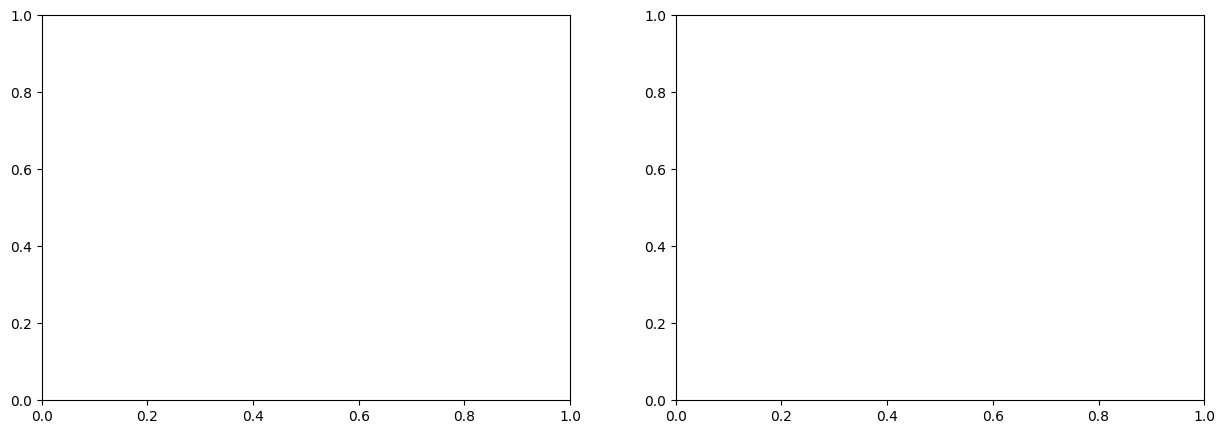

In [26]:
model_perf.show()

In [27]:
if False:
    grid_params = {}
    data = (train_data, train_labels, val_data, val_labels, test_data, test_labels)
    utils.grid_search(params, grid_params, *data, model=lambda x: models.cgcnn(L,**x))